# EVALUATING AUTOENCODERS

The evaluation encompasses
* **Function recovery**. Can the autoencoder accurately recover time courses from reaction networks.
* **Insightful interpretation**. Does the autoencoder produce a low dimension representation that provides useful insights.

The initial focus is on function recovery. To gain insight into the effectiveness of autoencoders for this task, we start by considering synthetic time courses to investigate the ability of autoencoderes to recover functions similar to those used in rate laws of biological systems.

# Preliminaries

In [1]:
from autoencodersb import constants as cn
from autoencodersb.data_generator import DataGenerator
from autoencodersb.polynomial_collection import PolynomialCollection
from autoencodersb.model_runner_pca import ModelRunnerPCA
from autoencodersb.model_runner_nn import ModelRunnerNN
from autoencodersb.autoencoder import Autoencoder
from autoencodersb.sequence import Sequence

import numpy as np
import pandas as pd

# Helpers

# Evaluation Data

Below we describe the data used to evaluate autoencoders.

The emphasis is on time series similar to those encountered in biological models. Our approach is to consider the functional form of common rate laws. These typically consist of a single term that is one of the following:

* A constant times the concentration of a floating species. This is a first order polynomal.
    * $A \rightarrow B;~ kA$.
* A constant times a the product of concentrations of two floatin species. This is a second order polynomial.
    * $A B \rightarrow C;~ k A B$
* An ratio of polynomials for Michaelis-Menten and Hill Equations
    * $A \rightarrow B; ~ \frac{v A^n}{(k + A^n)}$

We consider tree different time series for the floating species in a rate law
* Linear: $A = kt$, where $k$ is a fixed constant
* Exponential: $A = e^{-r t}$
* Exponential integeral: $A = 1 - e^{-r t}/r$

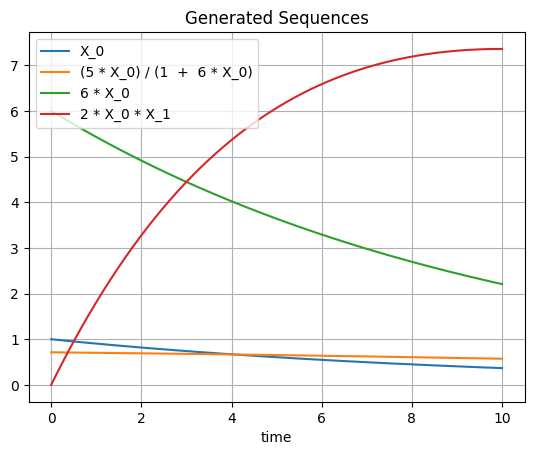

In [23]:
polynomial_collection = PolynomialCollection.make(
        is_mm_term=True,
        is_first_order_term=True,
        is_second_order_term=True,
        is_third_order_term=False)
num_point = 2000
end_time = 10
GENERATOR = DataGenerator(polynomial_collection=polynomial_collection,
        num_sample=num_point)
sequences = [Sequence(num_point=num_point, end_time=end_time, rate=0.1, seq_type=cn.SEQ_EXPONENTIAL),
             Sequence(num_point=num_point, end_time=end_time, seq_type=cn.SEQ_LINEAR)]
GENERATOR.specifySequences(sequences=sequences)
DATA_DL = GENERATOR.generate()
GENERATOR.plotGeneratedData(x_column="X_1")
DATA_DF = GENERATOR.data_df

In [24]:
GENERATOR.data_df

,X_0,X_1,(5 * X_0) / (1 + 6 * X_0),6 * X_0,2 * X_0 * X_1
0,1.000000,0.000000,0.714286,6.000000,0.000000
1,0.999500,0.005003,0.714235,5.996999,0.010000
2,0.999000,0.010005,0.714184,5.994000,0.019990
3,0.998500,0.015008,0.714132,5.991002,0.029970
4,0.998001,0.020010,0.714081,5.988006,0.039940
...,...,...,...,...,...
1995,0.368616,9.979990,0.573865,2.211698,7.357574
1996,0.368432,9.984992,0.573776,2.210592,7.357581
1997,0.368248,9.989995,0.573686,2.209486,7.357585
1998,0.368064,9.994997,0.573597,2.208381,7.357588


# TO DO

1. Test Hill ratio terms
2. Select synthetic data for evaluations
3. Evaluate w.r.t. PCA